# 1D regression understanding

# Understaning regression objective and optimization gradients

In this notebook we will dive into geometric understanding of linear regression loss function, gradient and optimization.

we start by creating a toy dataset and traing linear regresion model. 

then compute gradients manually and using PyTorch autograd

## Setup project

In [82]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
from pathlib import Path
import sys
import os
proj_dir = r"D://learning//understanding_dl"
# add project dir to path
sys.path.append(proj_dir)
# change working dir to project dir
os.chdir(proj_dir)
os.getcwd()

'D:\\learning\\understanding_dl'

In [84]:
import math
from collections import defaultdict
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import AdamW
from tqdm import tqdm
import seaborn as sns
from torch.distributions import Uniform, Normal

from src.visualization import View3D

In [85]:
# hyperparams
epochs = 100000
regularization = False
lamda = 0.1

## 1. Create toy dataset

In [86]:
N = 1000
seed = 25 # for reporducibility
torch.manual_seed(seed)

# line equation params
m, b = 10, 20
noise_var = 500
X = torch.linspace(-10, 10, N).view(-1, 1)
true_eq = f"{b} + {m}x"
Y = b + m * X  + math.sqrt(noise_var) * torch.randn_like(X)


### Visualize data

Text(0.5, 1.0, 'Traing data')

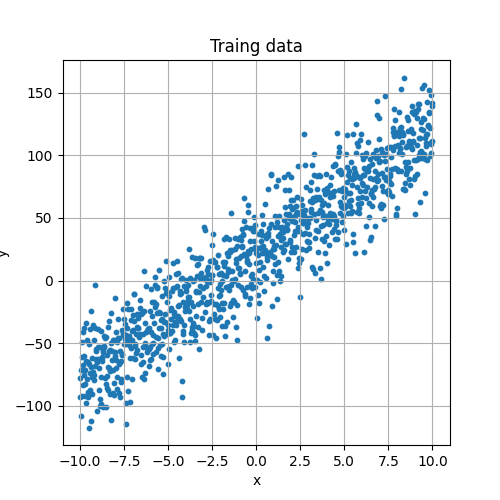

In [87]:

plt.figure(figsize=(5, 5))
plt.scatter(X, Y, s=10)
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.title('Traing data')

## 2. Build model

In [88]:
class Regression1D(nn.Module):
    def __init__(self):
        super().__init__()

        # define parameters of the model
        self.a0 = nn.Parameter(torch.randn(1))
        self.a1 = nn.Parameter(torch.randn(1))
    
    def forward(self, x):
        return self.a0 + self.a1 * x

class RegularizedMSE(nn.Module):
    def __init__(self, l2_reg: bool = True, lamda=0.1, model=None):
        super().__init__()

        self.l2_reg = l2_reg
        self.lamda = lamda
        self.model = model


    def forward(self, y_pred: torch.Tensor, y_true:torch.Tensor):
        
        data_loss = torch.mean((y_pred - y_true)**2)

        if self.l2_reg:
            if self.model is None:
                raise ValueError(f"to use L2 reguralization model should be provided")
            # squared norm sum(w_i^2), not norm; normally bias are not included
            sq_norm = torch.stack([torch.norm(p, p=2)**2 for p in self.model.parameters()]).sum()

            return data_loss + self.lamda * sq_norm
        else:
            return data_loss

class ManualGrad:
    def __init__(self, model, l2_reg=False, lamda=0.1):
        self.X = None
        self.Y = None
        self.model = model
        self.l2_reg = l2_reg
        self.lamda = lamda


    def get_grads(self, X, Y):
        
        self.X = X
        self.Y = Y

        # get residues r_i = y_pred - y_true
        self.ri = self.residues()
        
        dlda0 = self.dl_da0()
        dlda1 = self.dl_da1()

        return dlda0, dlda1
    

    def dl_da0(self):

        if not self.l2_reg:
            return 2 * torch.mean(self.ri)
        else:
            return 2 * torch.mean(self.ri) + 2 * self.lamda * self.model.a0

    def dl_da1(self):
        if not self.l2_reg:
            return 2 * torch.mean(self.X * self.ri)
        else:
            return 2 * torch.mean(self.X * self.ri) + 2 * self.lamda * self.model.a1

    
    def residues(self):
        
        y_pred = self.model(X)
        
        return y_pred - self.Y

## 3. Train model

In [89]:
def train(model, epochs, optimizer, criterion, l2_reg, manual_grad=None):
    info  = defaultdict(list)
    for e in tqdm(range(epochs), desc='training'):

        # y = a0 + a1 * x_data
        y_pred = model(X)

        loss = criterion(y_pred, Y)

        # compute gradient: dloss/dparams
        loss.backward()

        if e % 100 == 0:
            info['params_val'].append((model.a0.item(), model.a1.item()))
            info['grad_hist'].append((model.a0.grad.item(), model.a1.grad.item()))

            if manual_grad is not None:
                # manual_grad = manual_grad(X, Y, model, l2_reg=l2_reg)
                grads = manual_grad.get_grads(X, Y)
                info['manual_grad_hist'].append(grads)
            info['epoch'].append(e)
            info['loss'].append(loss.item())
        
        # update params: p_i += lr * 
        optimizer.step()
        # clear gradients
        optimizer.zero_grad()
        

    info = {k: torch.tensor(v).detach() for k, v in info.items()}

    return info


In [90]:
# instantiate a model, define criterion and optimizisation
model = Regression1D()
optimizer = AdamW(params=model.parameters(), lr=0.0001)
criterion = RegularizedMSE(l2_reg=regularization, lamda=lamda, model=model)
manual_grad = ManualGrad(model=model, l2_reg=regularization, lamda=lamda)
info = train(model, epochs, optimizer, criterion, regularization, manual_grad=manual_grad)


training: 100%|██████████| 100000/100000 [00:30<00:00, 3303.12it/s]


In [91]:
torch.sum(info['loss'].isnan())

tensor(0)

Text(0, 0.5, 'mse losses')

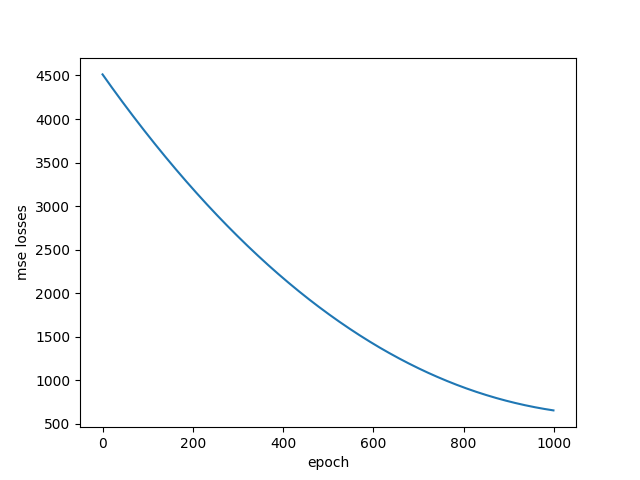

In [92]:
fig, ax= plt.subplots(1, 1)
ax.plot(range(info['loss'].numel()), info['loss'])
plt.xlabel('epoch')
plt.ylabel('mse losses')

In [93]:
ax = plt.subplot(111)
# ax.plot(range(info['loss'].numel()), info['loss'], zs=0)
plt.xlabel('epoch')
plt.ylabel('mse losses')

Text(36.902777777777786, 0.5, 'mse losses')

## How does the parameter values evolve over time?

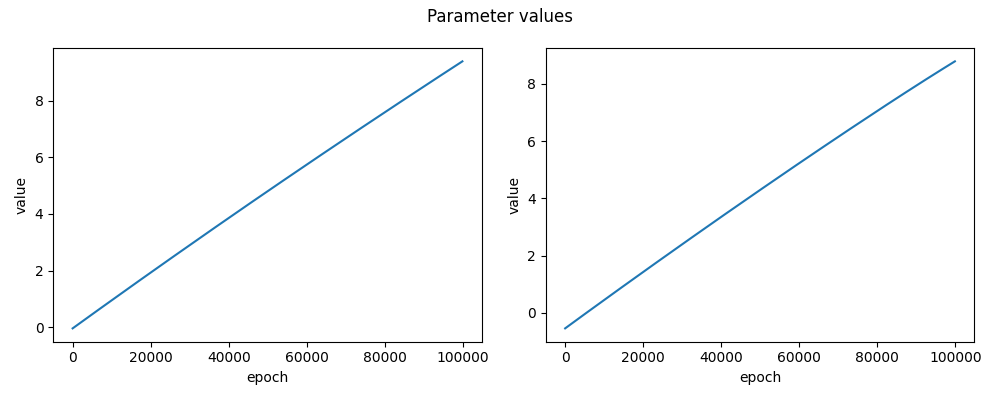

In [94]:
k = 'params_val'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle('Parameter values')
axes[0].plot( info['epoch'], info[k][:, 0])
axes[1].plot(info['epoch'], info[k][:, 1])
axes[0].set_xlabel('epoch')
axes[1].set_xlabel('epoch')
axes[0].set_ylabel('value')
axes[1].set_ylabel('value')
plt.tight_layout()


## Check manual vs auto-grad values

In [95]:
# |a_i - b_i| <= rtol * |b_i| + atol
torch.allclose(info['grad_hist'], info['manual_grad_hist'], rtol=0.001, atol=0.002 )

True

## distribution of gradients

In [96]:
grad_ratio = torch.mean(info['grad_hist'][:, 1]/ info['grad_hist'][:, 0])
print(f"mean dlda1/dlda0:{grad_ratio.item()}")

mean dlda1/dlda0:11.286267280578613


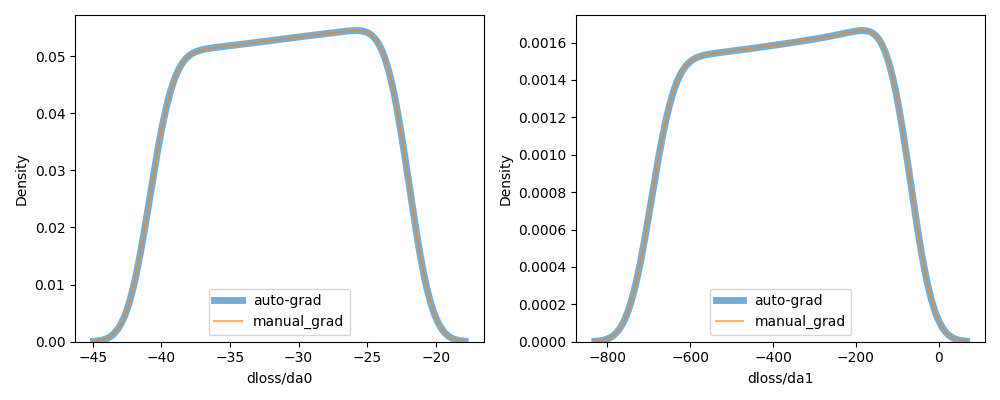

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# for k in ['grad_hist', 'manual_grad_hist']:

# distribution of dloss/da0
sns.kdeplot(info['grad_hist'][:, 0], ax=axes[0], label='auto-grad', alpha=0.6, linewidth=5)
sns.kdeplot(info['manual_grad_hist'][:, 0], ax=axes[0], label='manual_grad', alpha=0.6)
axes[0].set_xlabel('dloss/da0')
axes[0].legend()

# distribution of dloss/da1
sns.kdeplot(info['grad_hist'][:, 1], ax=axes[1], label='auto-grad', alpha=0.6, linewidth=5)
sns.kdeplot(info['manual_grad_hist'][:, 1], ax=axes[1], label='manual_grad', alpha=0.6)
axes[1].set_xlabel('dloss/da1')
axes[1].legend()

plt.tight_layout()



gradients in the slope param direction are much higher than in the intercept direction

is this true from surface or contour plots

## fitting a line

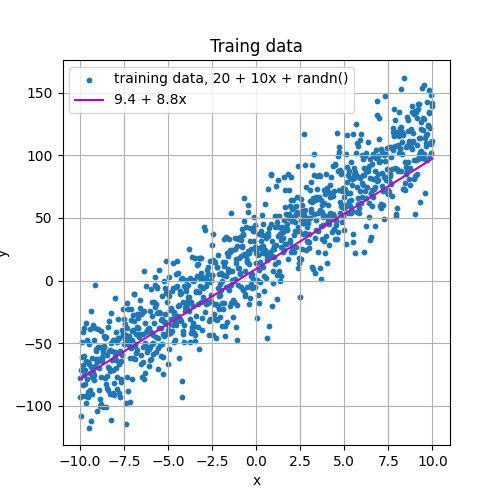

In [103]:
plt.figure(figsize=(5, 5))
plt.scatter(X, Y, s=10, label=f'training data, {true_eq} + randn()')
line = f"{round(model.a0.detach().item(), 2)} + {round(model.a1.detach().item(), 2)}x"
plt.plot(X, model.a0.detach() + model.a1.detach() * X, label=f'{line}', color='m')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.title('Traing data')
plt.legend()

## Visualisation of loss and learning landscape

In [99]:
from src.visualization import View3D, View3DNew
%matplotlib widget
def mse(X, Y, A0, A1):

    Y_hat = A0[:, :, None] + X.view(1, 1, -1) * A1[:, :, None]
    loss = torch.mean((Y_hat - Y.view(1, 1, -1))**2, dim=-1)

    return loss


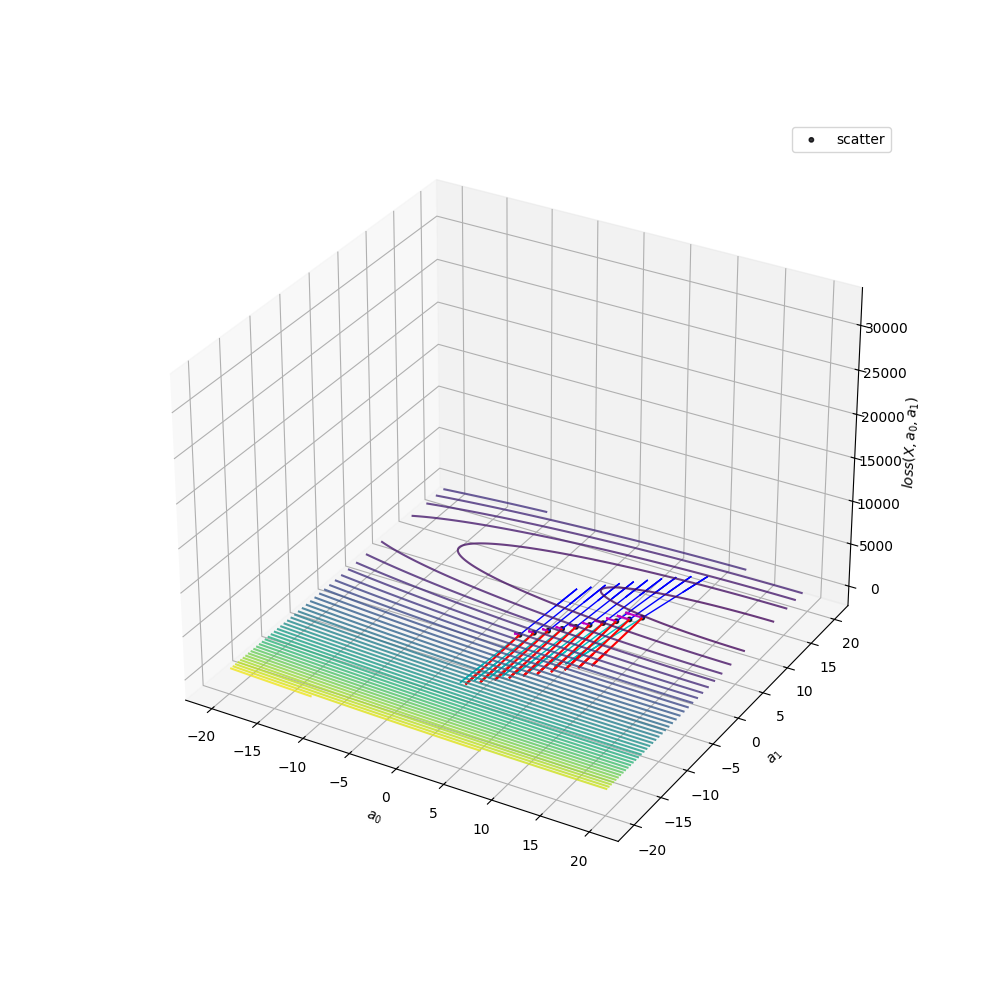

In [ ]:
plt.close('all')  
grad_normalize = False  
contour = True

#  Grid mesh points
M = 300
P = 20
a0 = torch.linspace(-P, P, M)
a1 = torch.linspace(-P, P, M)
A0, A1 = torch.meshgrid(a0, a1) # Both of them M x M
A0.requires_grad = False
A1.requires_grad = False

# calculate data loss  
# X --> (N, 1) --to-->(1, 1, N), Y --> (N, 1) --to-->(1, 1, N);
#  A0, A1 need to be broadcasted to (MxMx1)
loss =  mse(X, Y, A0, A1)


xyz = torch.stack([A0, A1, loss])
viewer = View3D(xyz=xyz, figsize=(10, 10))

# Scater plots of optmization steps para value
step = 100
scale = 0.01

xyz = torch.cat([info['params_val'], info['loss'].view(-1, 1)], dim=1).transpose(1, 0)

# Gradients vectos at specific parameter values stored during training
# gradients vectors for optimization steps vectors; the gradient in the z direction is 0
grads = torch.cat([info['grad_hist'], torch.zeros_like(info['grad_hist'][:, 0]).view(-1, 1)], dim=1).transpose(1, 0) * scale
pos = torch.cat([info['params_val'],  info['loss'].view(-1, 1)], dim=1).transpose(1, 0)

if contour:
    xyz[2, :] = 0.0
    pos[2, :] = 0.0


if contour:
    viewer.contour()
else:
    viewer.surface()
viewer.scatter(xyz=xyz[:, ::100], z_as_color=True,)



if not grad_normalize:
    grads = 10 * grads / torch.norm(grads, p=2, dim=0)

viewer.quiver(xyz=pos[:, ::step], uvw=grads[:, ::step,], color='c', normalize=grad_normalize)
viewer.quiver(xyz=pos[:, ::step], uvw=-grads[:, ::step,], color='b', normalize=grad_normalize)

# plot x and y gradients
viewer.quiver_x_component(xyz=pos[:, ::step], uvw=grads[:, ::step,], normalize=False, color='m')
viewer.quiver_y_component(xyz=pos[:, ::step], uvw=grads[:, ::step,], normalize=False, color='r')

viewer.set_xlabel(r'$a_0$')
viewer.set_ylabel(r'$a_1$')
viewer.set_zlabel(r'$loss(X, a_0, a_1)$')


viewer.show()


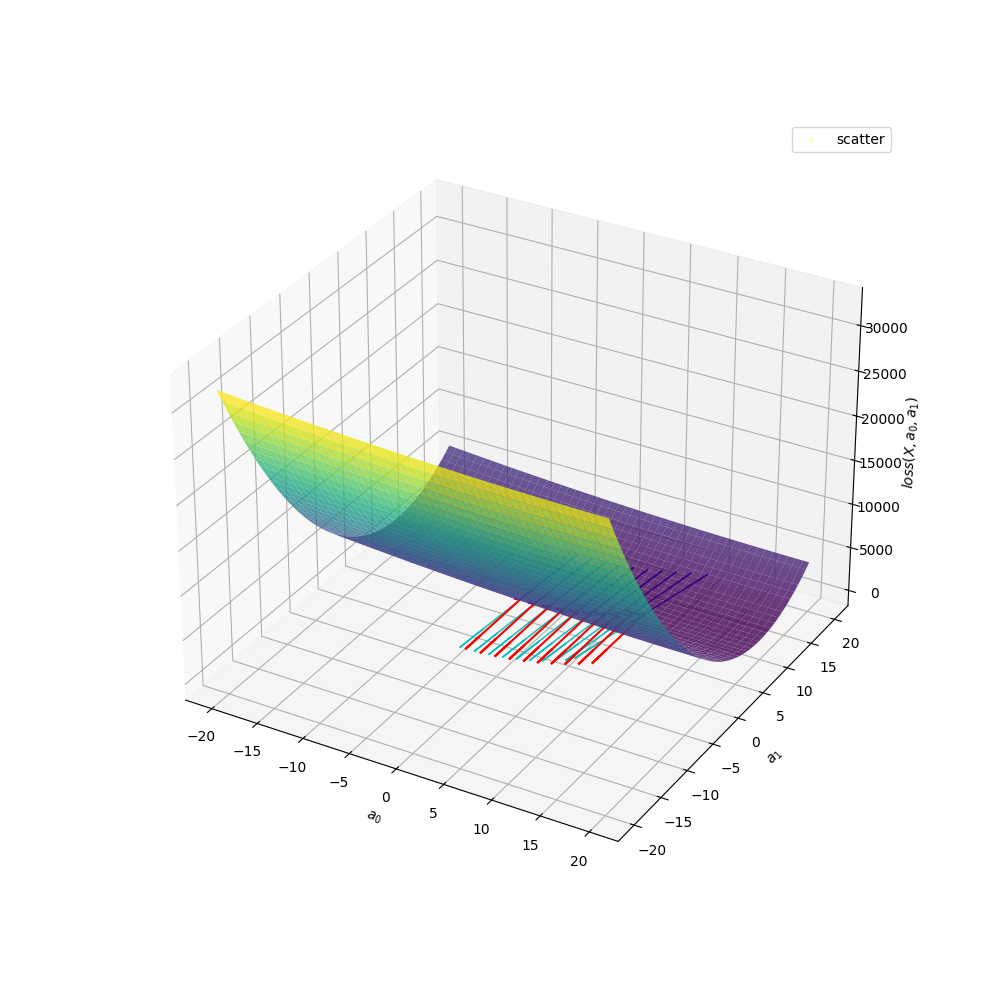

In [101]:

grad_normalize = False  
contour = False

#  Grid mesh points
M = 300
P = 20
a0 = torch.linspace(-P, P, M)
a1 = torch.linspace(-P, P, M)
A0, A1 = torch.meshgrid(a0, a1) # Both of them M x M
A0.requires_grad = False
A1.requires_grad = False

# calculate data loss  
# X --> (N, 1) --to-->(1, 1, N), Y --> (N, 1) --to-->(1, 1, N);
#  A0, A1 need to be broadcasted to (MxMx1)
loss =  mse(X, Y, A0, A1)


xyz = torch.stack([A0, A1, loss])
viewer = View3D(xyz=xyz, figsize=(10, 10))

# Scater plots of optmization steps para value
step = 100
scale = 0.01

xyz = torch.cat([info['params_val'], info['loss'].view(-1, 1)], dim=1).transpose(1, 0)

# Gradients vectos at specific parameter values stored during training
# gradients vectors for optimization steps vectors; the gradient in the z direction is 0
grads = torch.cat([info['grad_hist'], torch.zeros_like(info['grad_hist'][:, 0]).view(-1, 1)], dim=1).transpose(1, 0) * scale
pos = torch.cat([info['params_val'],  info['loss'].view(-1, 1)], dim=1).transpose(1, 0)

if contour:
    xyz[2, :] = 0.0
    pos[2, :] = 0.0


if contour:
    viewer.contour()
else:
    viewer.surface()
viewer.scatter(xyz=xyz[:, ::100], z_as_color=True,)


if not grad_normalize:
    grads = 10 * grads / torch.norm(grads, p=2, dim=0)

viewer.quiver(xyz=pos[:, ::step], uvw=grads[:, ::step,], color='c', normalize=grad_normalize)
viewer.quiver(xyz=pos[:, ::step], uvw=-grads[:, ::step,], color='b', normalize=grad_normalize)

# plot x and y gradients
viewer.quiver_x_component(xyz=pos[:, ::step], uvw=grads[:, ::step,], normalize=False, color='m')
viewer.quiver_y_component(xyz=pos[:, ::step], uvw=grads[:, ::step,], normalize=False, color='r')

viewer.set_xlabel(r'$a_0$')
viewer.set_ylabel(r'$a_1$')
viewer.set_zlabel(r'$loss(X, a_0, a_1)$')


viewer.show()


- gradient direction - cyan;
- negative of grad direction - blue;
- x or a0 or y intercept component - magenta
- y or a1 or slope componte - red

## What do we observe:
- the rate of change of loss in the direction of slope is much higher than in the direction of y-intercept gradient
    - which is evident from the survace plot and distribution og gradients plot
    - in the surface and contour plots, while ploting, for the purpose of visualisation, gradient are normalise to unite vector
- Gradient point in the direction of maximum rate of change of the loss, and neg gradient points in the direction of max dencent of the loss

### loss profile when either of the parameters are fixed

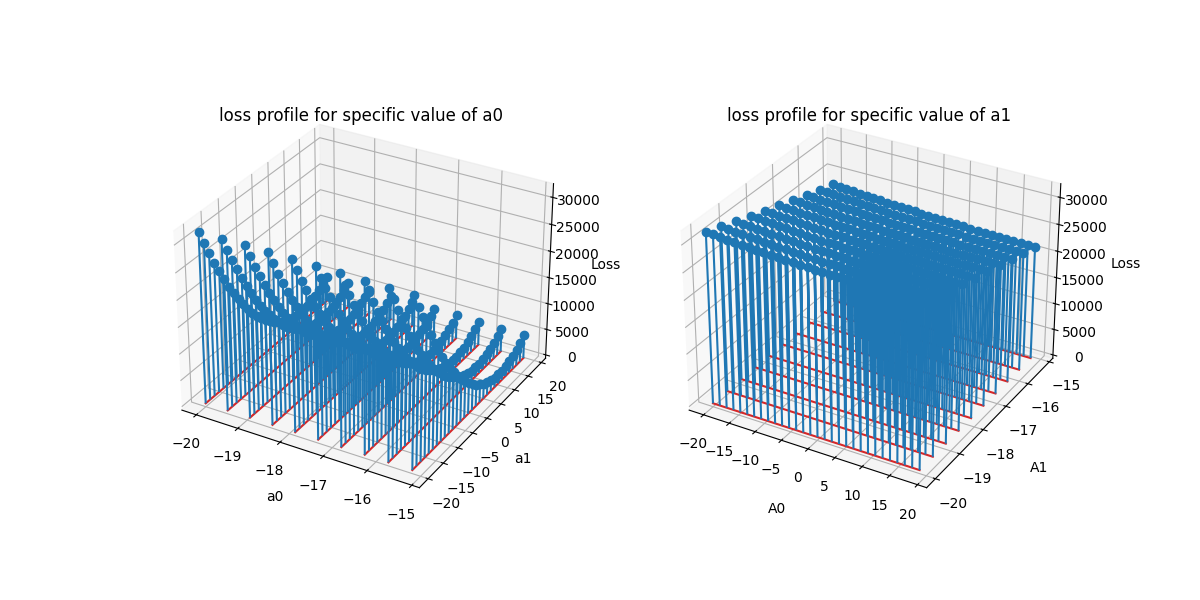

In [143]:


#  Grid mesh points
M = 300
P = 20
a0 = torch.linspace(-P, P, M)
a1 = torch.linspace(-P, P, M)
A0, A1 = torch.meshgrid(a0, a1) # Both of them M x M
A0.requires_grad = False
A1.requires_grad = False

# calculate data loss  
# X --> (N, 1) --to-->(1, 1, N), Y --> (N, 1) --to-->(1, 1, N);
#  A0, A1 need to be broadcasted to (MxMx1)
loss =  mse(X, Y, A0, A1)

n = 10# number of points in fixed parameter
ks = torch.arange(0, 2*P)[::(2*P // n)] # fixed param value index
step=10

fig = plt.figure(figsize=(12, 6))

# plot loss profile for fixed values of a0, intercept
ax = fig.add_subplot(121, projection='3d')
ax.set_title('loss profile for specific value of a0', y=0.99)

for k in ks:
    ax.stem(A0[k, :].numpy()[::step], A1[k, :].numpy()[::step], loss[k, :].numpy()[::step], )
ax.set_xlabel('a0')
ax.set_ylabel('a1')
ax.set_zlabel('Loss')

# plot loss profile of a1, slope
ax = fig.add_subplot(122, projection='3d')
ax.set_title('loss profile for specific value of a1', y=0.99)

for k in ks:
    ax.stem(A0[:, k].numpy()[::step], A1[:, k].numpy()[::step], loss[:, k].numpy()[::step], )
ax.set_xlabel("A0", labelpad=10)
ax.set_ylabel("A1", labelpad=10)
ax.set_zlabel("Loss", labelpad=10)

plt.show()

The rate of change of loss wrt slope is higher compared with that of intercept.

# summary

- gradient points in the direction of max increase of the loss
- some prameters have larger gradient than others